In [3]:
!pip install datasets

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from datasets import load_dataset

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

dataset = load_dataset("squad")

def format_sample(example):
    answer = example["answers"]["text"][0] if example["answers"]["text"] else "N/A"
    return {
        "text": f"Q: {example['question']}\nContext: {example['context']}\nA: {answer}"
    }

formatted_dataset = dataset.map(format_sample)

def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    encoding["labels"] = encoding["input_ids"][:]
    return encoding


tokenized = formatted_dataset.map(tokenize, batched=True)

small_train = tokenized["train"].select(range(2000))

small_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=True)

train_loader = DataLoader(small_train, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [5]:
tp = list(small_train["context"])

In [6]:
!pip install sentence_transformers

In [7]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')




In [8]:
embeddings = embedder.encode(tp)
print(embeddings.shape)


(2000, 384)


In [9]:
small_train

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from datasets import load_dataset

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

dataset = load_dataset("squad")

def format_sample(example):
    answer = example["answers"]["text"][0] if example["answers"]["text"] else "N/A"
    return {
        "text": f"Q: {example['question']}\nContext: {example['context']}\nA: {answer}"
    }

formatted_dataset = dataset.map(format_sample)

def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    encoding["labels"] = encoding["input_ids"][:]
    return encoding


tokenized = formatted_dataset.map(tokenize, batched=True)

small_train = tokenized["train"].select(range(2000))

small_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=True)

train_loader = DataLoader(small_train, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)




Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [11]:
losses = []
positions = []

In [12]:
#device = torch.device("cpu")


In [13]:
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model.gradient_checkpointing_enable()
model.to(device)

train_loader = DataLoader(small_train, batch_size=1, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

losses, positions = [], []

for step, batch in enumerate(train_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    optimizer.zero_grad()

    with autocast():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    losses.append(loss.item())
    positions.append(embedder.encode(small_train["context"][step], device="cpu"))

    print(f"Step {step}, Loss: {loss.item():.4f}")


/tmp/ipython-input-74020088.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-74020088.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step 0, Loss: 7.0416
Step 1, Loss: 4.2971
Step 2, Loss: 4.6891
Step 3, Loss: 3.8078
Step 4, Loss: 3.5470
Step 5, Loss: 3.8601
Step 6, Loss: 3.4988
Step 7, Loss: 3.8725
Step 8, Loss: 3.9782
Step 9, Loss: 4.3688
Step 10, Loss: 3.5062
Step 11, Loss: 3.5529
Step 12, Loss: 3.1725
Step 13, Loss: 3.4826
Step 14, Loss: 4.5683
Step 15, Loss: 3.5855
Step 16, Loss: 3.1887
Step 17, Loss: 3.2953
Step 18, Loss: 3.3060
Step 19, Loss: 3.1497
Step 20, Loss: 3.9346
Step 21, Loss: 2.5035
Step 22, Loss: 3.1594
Step 23, Loss: 4.3717
Step 24, Loss: 3.7197
Step 25, Loss: 3.6233
Step 26, Loss: 3.0650
Step 27, Loss: 3.3150
Step 28, Loss: 3.8234
Step 29, Loss: 4.7397
Step 30, Loss: 3.2613
Step 31, Loss: 2.5980
Step 32, Loss: 2.8899
Step 33, Loss: 3.3329
Step 34, Loss: 4.0424
Step 35, Loss: 5.6636
Step 36, Loss: 3.1174
Step 37, Loss: 3.6623
Step 38, Loss: 3.8529
Step 39, Loss: 3.7743
Step 40, Loss: 2.7422
Step 41, Loss: 3.3064
Step 42, Loss: 3.7285
Step 43, Loss: 3.2158
Step 44, Loss: 3.6399
Step 45, Loss: 3.687

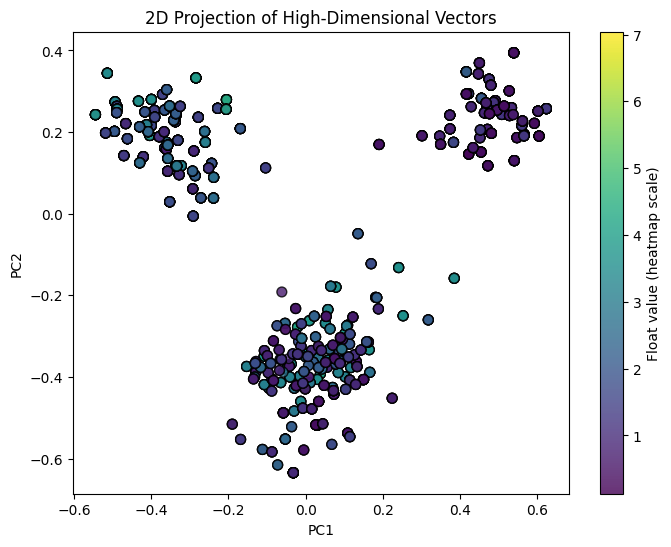

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data (replace with your own)
# Suppose you have 100 vectors, each 50-dimensional
vectors = np.array(positions)
float_values = np.array(losses)  # values in [0,1]

# ---- Step 1: Project to 2D ----
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# ---- Step 2: Scatter plot with heatmap coloring ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    vectors_2d[:, 0], vectors_2d[:, 1],
    c=float_values,              # color by float values
    cmap="viridis",              # heatmap style colormap
    s=50,                        # point size
    alpha=0.8,                   # transparency
    edgecolors="k"
)

plt.colorbar(scatter, label="Float value (heatmap scale)")
plt.title("2D Projection of High-Dimensional Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


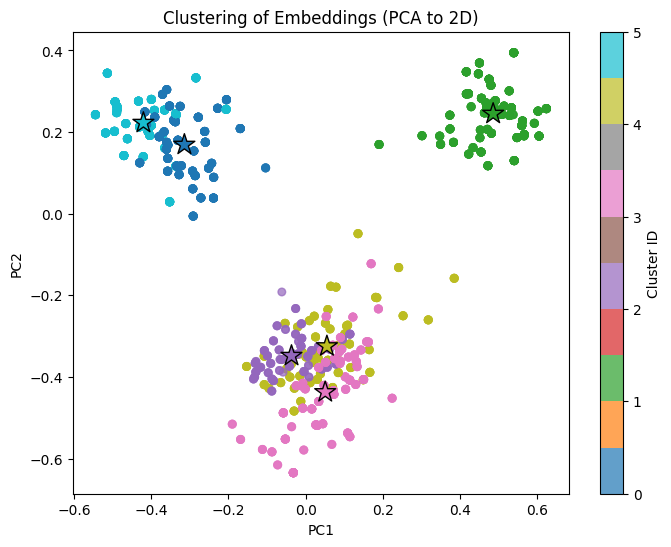

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ---- Prepare data ----
X = np.vstack(positions)   # (n_samples, embedding_dim)

# ---- Clustering ----
n_clusters = 6  # choose as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# ---- Cluster means (in embedding space) ----
cluster_means = []
for cluster_id in range(n_clusters):
    cluster_points = X[labels == cluster_id]
    cluster_mean = cluster_points.mean(axis=0)
    cluster_means.append(cluster_mean)
cluster_means = np.vstack(cluster_means)

# ---- Project to 2D for visualization ----
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
means_2d = pca.transform(cluster_means)

# ---- Plot ----
plt.figure(figsize=(8, 6))

# plot points
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels, cmap="tab10", s=30, alpha=0.7
)

# plot cluster centers
plt.scatter(
    means_2d[:, 0], means_2d[:, 1],
    c=range(n_clusters),
    cmap="tab10",
    marker="*", s=250, edgecolors="k"
)

plt.title("Clustering of Embeddings (PCA to 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


In [16]:
cluster_means.shape

(6, 384)

In [17]:
import numpy as np

In [18]:
center = np.mean(embeddings,axis=0)

In [19]:
np.max(np.abs(np.linalg.norm(embeddings - np.array(center),axis=1)))

np.float32(1.0767293)

In [20]:
embeddings - center

array([[ 0.03778994,  0.16363981,  0.00110093, ...,  0.05578354,
         0.01580423,  0.00443124],
       [ 0.03778994,  0.16363981,  0.00110093, ...,  0.05578354,
         0.01580423,  0.00443124],
       [ 0.03778994,  0.16363981,  0.00110093, ...,  0.05578354,
         0.01580423,  0.00443124],
       ...,
       [ 0.03235526,  0.01681057,  0.02856543, ...,  0.1302164 ,
        -0.07012999,  0.00710194],
       [ 0.03235526,  0.01681057,  0.02856543, ...,  0.1302164 ,
        -0.07012999,  0.00710194],
       [ 0.03235526,  0.01681057,  0.02856543, ...,  0.1302164 ,
        -0.07012999,  0.00710194]], dtype=float32)

In [21]:
goalr = np.sum(np.abs(np.linalg.norm(embeddings - np.array(center),axis=1)))

In [22]:
goalr

np.float32(1893.3303)

In [23]:
expected_lr = 5e-5*2000

In [24]:
#batch["context"]

In [25]:
#np.abs(np.linalg.norm(np.array(embedder.encode(batch["context"][1])) - np.array(center)))


In [26]:
"""import numpy as np
from datasets import Dataset

# 1. Convert small_train back into HF Dataset with "context"
# formatted_dataset["train"] already has "context"
subset = formatted_dataset["train"].select(range(2000))

# 2. Precompute embeddings for all contexts
context_embeddings = [embedder.encode(ctx, device="cpu") for ctx in subset["context"]]

# 3. Compute min distance to cluster means for each context
distances = []
for emb in context_embeddings:
    temp = [np.linalg.norm(np.array(emb) - np.array(cluster_means[i])) for i in range(len(cluster_means))]
    distances.append(min(temp))

# 4. Add distances as a new column
subset = subset.add_column("sorting_column", distances)

# 5. Sort dataset
sorted_dataset = subset.sort("sorting_column")

# 6. Split into two halves
train_dataset1 = sorted_dataset.select(range(1000))
train_dataset2 = sorted_dataset.select(range(1000, 2000))

# 7. Convert to torch-format + dataloaders
train_dataset1.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_dataset2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_loader1 = DataLoader(train_dataset1, batch_size=1, shuffle=False)
train_loader2 = DataLoader(train_dataset2, batch_size=1, shuffle=False)
"""

'import numpy as np\nfrom datasets import Dataset\n\n# 1. Convert small_train back into HF Dataset with "context"\n# formatted_dataset["train"] already has "context"\nsubset = formatted_dataset["train"].select(range(2000))\n\n# 2. Precompute embeddings for all contexts\ncontext_embeddings = [embedder.encode(ctx, device="cpu") for ctx in subset["context"]]\n\n# 3. Compute min distance to cluster means for each context\ndistances = []\nfor emb in context_embeddings:\n    temp = [np.linalg.norm(np.array(emb) - np.array(cluster_means[i])) for i in range(len(cluster_means))]\n    distances.append(min(temp))\n\n# 4. Add distances as a new column\nsubset = subset.add_column("sorting_column", distances)\n\n# 5. Sort dataset\nsorted_dataset = subset.sort("sorting_column")\n\n# 6. Split into two halves\ntrain_dataset1 = sorted_dataset.select(range(1000))\ntrain_dataset2 = sorted_dataset.select(range(1000, 2000))\n\n# 7. Convert to torch-format + dataloaders\ntrain_dataset1.set_format(type="torch

In [27]:
range_coef = 0.5

In [28]:
import numpy as np
from datasets import Dataset

# 1. Convert small_train back into HF Dataset with "context"
# formatted_dataset["train"] already has "context"
subset = formatted_dataset["train"].select(range(2000))

# 2. Precompute embeddings for all contexts
context_embeddings = [embedder.encode(ctx, device="cpu") for ctx in subset["context"]]

# 3. Compute min distance to cluster means for each context
distances = []
for emb in context_embeddings:
    temp = [np.linalg.norm(np.array(emb) - np.array(cluster_means[i])) for i in range(len(cluster_means))]
    distances.append(min(temp))

# 4. Add distances as a new column
subset = subset.add_column("sorting_column", distances)

In [79]:
def balanced_half(values):
    target = len(values) // 2

    # Always keep min and max
    chosen = [values[0], values[-1]]
    remaining = set(values[1:-1])
    res = []
    while len(chosen) < target and remaining:
        # Pick the point farthest from its nearest chosen neighbor
        best = max(remaining, key=lambda x: min(abs(x - c) for c in chosen))
        res.append(values.index(best))
        chosen.append(best)
        remaining.remove(best)

    return sorted(res)

# Example
vals = [1, 2, 3,3,3,3,3, 10, 11, 20, 21, 22]
print(balanced_half(vals))


[1, 2, 8, 9]


In [80]:
needed_indexes = balanced_half(sorted_dataset["sorting_column"])

In [81]:
needed_indexes

[0,
 12,
 27,
 47,
 66,
 76,
 89,
 101,
 118,
 130,
 144,
 160,
 174,
 185,
 197,
 200,
 212,
 229,
 234,
 248,
 260,
 265,
 278,
 291,
 300,
 311,
 322,
 332,
 346,
 360,
 373,
 375,
 387,
 401,
 407,
 420,
 427,
 440,
 451,
 465,
 469,
 476,
 491,
 505,
 519,
 529,
 540,
 542,
 545,
 554,
 558,
 565,
 573,
 583,
 595,
 604,
 612,
 628,
 643,
 648,
 653,
 658,
 663,
 666,
 676,
 689,
 694,
 697,
 702,
 706,
 710,
 715,
 719,
 724,
 737,
 745,
 756,
 774,
 779,
 790,
 802,
 814,
 815,
 828,
 833,
 836,
 846,
 857,
 862,
 871,
 881,
 883,
 887,
 892,
 901,
 904,
 909,
 921,
 926,
 938,
 939,
 947,
 953,
 954,
 966,
 971,
 976,
 981,
 984,
 993,
 998,
 1011,
 1018,
 1020,
 1025,
 1038,
 1048,
 1053,
 1061,
 1074,
 1078,
 1091,
 1096,
 1109,
 1114,
 1118,
 1123,
 1128,
 1133,
 1138,
 1150,
 1159,
 1164,
 1167,
 1178,
 1183,
 1188,
 1197,
 1201,
 1211,
 1213,
 1218,
 1223,
 1233,
 1237,
 1241,
 1245,
 1260,
 1265,
 1278,
 1289,
 1292,
 1297,
 1308,
 1312,
 1325,
 1330,
 1335,
 1350,
 1355,

In [82]:


# 5. Sort dataset


# 6. Split into two halves
train_dataset1 = sorted_dataset.select(range(1000))
train_dataset2 = sorted_dataset.select(range(1000, 2000))


train_dataset_coverage = sorted_dataset.select(needed_indexes)

train_dataset1 = train_dataset1.map(tokenize, batched=True)

train_dataset2  = train_dataset1.map(tokenize, batched=True)

train_dataset_coverage = train_dataset_coverage.map(tokenize, batched=True)


# 7. Convert to torch-format + dataloaders
train_dataset1.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_dataset2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_dataset_coverage.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


train_loader1 = DataLoader(train_dataset1, batch_size=1, shuffle=False)
train_loader2 = DataLoader(train_dataset2, batch_size=1, shuffle=False)

train_dataset_coverage = DataLoader(train_dataset_coverage, batch_size=1, shuffle=False)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

In [83]:
sorted_dataset["sorting_column"]

Column([0.5627016425132751, 0.5627016425132751, 0.5627016425132751, 0.5627016425132751, 0.5627016425132751])

In [84]:
distances = []
for i in range(2000):

  distances.append(min([np.linalg.norm(context_embeddings[i] - cm) for cm in cluster_means]))


In [89]:
balanced_half(sorted(distances))

[0,
 12,
 27,
 47,
 66,
 76,
 89,
 101,
 118,
 130,
 144,
 160,
 174,
 185,
 197,
 200,
 212,
 229,
 234,
 248,
 260,
 265,
 278,
 291,
 300,
 311,
 322,
 332,
 346,
 360,
 373,
 375,
 387,
 401,
 407,
 420,
 427,
 440,
 451,
 465,
 469,
 476,
 491,
 505,
 519,
 529,
 540,
 542,
 545,
 554,
 558,
 565,
 573,
 583,
 595,
 604,
 612,
 628,
 643,
 648,
 653,
 658,
 663,
 666,
 676,
 689,
 694,
 697,
 702,
 706,
 710,
 715,
 719,
 724,
 737,
 745,
 756,
 774,
 779,
 790,
 802,
 814,
 815,
 828,
 833,
 836,
 846,
 857,
 862,
 871,
 881,
 883,
 887,
 892,
 901,
 904,
 909,
 921,
 926,
 938,
 939,
 947,
 953,
 954,
 966,
 971,
 976,
 981,
 984,
 993,
 998,
 1011,
 1018,
 1020,
 1025,
 1038,
 1048,
 1053,
 1061,
 1074,
 1078,
 1091,
 1096,
 1109,
 1114,
 1118,
 1123,
 1128,
 1133,
 1138,
 1150,
 1159,
 1164,
 1167,
 1178,
 1183,
 1188,
 1197,
 1201,
 1211,
 1213,
 1218,
 1223,
 1233,
 1237,
 1241,
 1245,
 1260,
 1265,
 1278,
 1289,
 1292,
 1297,
 1308,
 1312,
 1325,
 1330,
 1335,
 1350,
 1355,

In [90]:
goalr = sum(distances)

In [91]:
goalr

np.float32(1567.2968)

In [92]:
aim = np.mean(distances)

In [93]:

# Training loop
for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    for step, batch in enumerate(train_loader1):
        # Get precomputed embedding for this sample
       # emb = context_embeddings[step]

        # Distance to cluster means
        #distances = [np.linalg.norm(emb - cm) for cm in cluster_means]
        #av = min(distances)
       #av = distances[step]
        # Adjust LR (with clamp)
        #balanced = 5e-5 - (range_coef*(av))*(5e-5)


       # balanced = range_coef*(1-(av/aim)) + 5e-5

        #new_lr = balanced*((expected_lr)/(goalr))
       # new_lr = max(1e-6, min(1e-4, balanced))
        #print(balanced,range_coef)
        #for param_group in optimizer.param_groups:
        #    param_group['lr'] = new_lr

        # Forward/backward
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if step % 10 == 0:
        #    print(f"Step {step}, Loss: {loss.item():.4f}, LR: {new_lr:.6f}")



Epoch 1
Epoch 2
Epoch 3


In [94]:
from torch.utils.data import DataLoader

small_eval = tokenized["validation"].select(range(200))

small_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

eval_loader = DataLoader(small_eval, batch_size=2)

model.eval()

total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches
print(f"Average evaluation loss: {avg_loss:.4f}")

perplexity = torch.exp(torch.tensor(avg_loss))
print(f"Perplexity: {perplexity:.4f}")


Average evaluation loss: 4.0112
Perplexity: 55.2138


In [95]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from datasets import load_dataset

model2 = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model2.resize_token_embeddings(len(tokenizer))

dataset = load_dataset("squad")

def format_sample(example):
    answer = example["answers"]["text"][0] if example["answers"]["text"] else "N/A"
    return {
        "text": f"Q: {example['question']}\nContext: {example['context']}\nA: {answer}"
    }

formatted_dataset = dataset.map(format_sample)

def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    encoding["labels"] = encoding["input_ids"][:]
    return encoding


tokenized = formatted_dataset.map(tokenize, batched=True)

small_train = tokenized["train"].select(range(2000))

small_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=True)

train_loader = DataLoader(small_train, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=5e-5)

model2.train()
for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    for step, batch in enumerate(train_loader2):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if step % 10 == 0:
        #    print(f"Step {step}, Loss: {loss.item():.4f}")


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Epoch 1
Epoch 2
Epoch 3


In [96]:
from torch.utils.data import DataLoader

small_eval = tokenized["validation"].select(range(200))

small_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

eval_loader = DataLoader(small_eval, batch_size=2)

model2.eval()

total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches
print(f"Average evaluation loss: {avg_loss:.4f}")

perplexity = torch.exp(torch.tensor(avg_loss))
print(f"Perplexity: {perplexity:.4f}")


Average evaluation loss: 3.3656
Perplexity: 28.9495


EQUAL COVERAGES

In [98]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from datasets import load_dataset

model3 = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model3.resize_token_embeddings(len(tokenizer))

dataset = load_dataset("squad")

def format_sample(example):
    answer = example["answers"]["text"][0] if example["answers"]["text"] else "N/A"
    return {
        "text": f"Q: {example['question']}\nContext: {example['context']}\nA: {answer}"
    }

formatted_dataset = dataset.map(format_sample)

def tokenize(example):
    encoding = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    encoding["labels"] = encoding["input_ids"][:]
    return encoding


tokenized = formatted_dataset.map(tokenize, batched=True)

small_train = tokenized["train"].select(range(2000))

small_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=True)

train_loader = DataLoader(small_train, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

optimizer = torch.optim.AdamW(model3.parameters(), lr=5e-5)

model3.train()
for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    for step, batch in enumerate(train_dataset_coverage):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model3(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #if step % 10 == 0:
        #    print(f"Step {step}, Loss: {loss.item():.4f}")


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Epoch 1
Epoch 2
Epoch 3


In [99]:
from torch.utils.data import DataLoader

small_eval = tokenized["validation"].select(range(200))

small_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

eval_loader = DataLoader(small_eval, batch_size=2)

model3.eval()

total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model3(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        num_batches += 1

avg_loss = total_loss / num_batches
print(f"Average evaluation loss: {avg_loss:.4f}")

perplexity = torch.exp(torch.tensor(avg_loss))
print(f"Perplexity: {perplexity:.4f}")


Average evaluation loss: 2.3190
Perplexity: 10.1657
